Импортируем нужные библиотеки.

In [1]:
#!python -m pip install featuretools

In [2]:
#!python -m pip install featuretools[complete]
#!python -m pip install featuretools[update_checker]
!pip install --user --upgrade catboost

Requirement already up-to-date: catboost in c:\users\user 1\appdata\roaming\python\python37\site-packages (0.22)


In [3]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from catboost import CatBoostClassifier


Распакуйте архив с данными в папку,где находится этот jupyter notebook (baseline.ipynb). У вас будет папка data,  содержащая необходимые файлы. 

Ваша задача предсказать вероятность совершения покупки Клиентом в определенных 8 категориях в следующие 7 дней, чтобы под них Банк смог направить релевантный контент (подборки). Для подготовки предсказания у вас есть данные по транзакциям 50 000 Клиентов в течение года, из которых 25 000 – в обучающей выборке и 25 000 – в тестовой. Ваша задача для тестовой выборки рассчитать для каждой из целевой категории вероятность совершения покупки в ней на следующей неделе.

Данные по транзакциям находятся в файле **transactions_train.csv**. Информация о покупках по категориям для исследуемой недели находится в файле **train_target.csv**.

Считаем данные по транзакциям и правильные ответы.

In [4]:
transactions_train=pd.read_csv('data_final/transactions_train.csv')

In [5]:
train_target=pd.read_csv('data_final/train_target.csv')

Посмотрим на данные.

In [6]:
transactions_train.head(5)

,client_dk,trans_date,amount,small_group
0,43976,0,4.563,2
1,8417,0,48.342,0
2,17309,0,12.320,0
3,33523,0,29.005,6
4,24228,0,10.266,6


* client_dk - уникальный идентификатор клиента
* trans_date - дата совершения транзакции
* amount - сумма транзакции
* small_group - категория покупки

In [7]:
train_target.head(5)

,client_dk,27,32,41,45,67,73,81,88
0,39762,1,0,0,0,0,0,0,0
1,10586,0,0,0,1,0,0,0,0
2,40115,0,1,0,0,0,0,0,0
3,34543,0,0,0,1,0,0,0,0
4,5372,0,0,0,1,0,0,0,0


* client_dk - уникальный идентификатор клиента, соответствует полю client_dk из транзакций
* числовые названия колонок - это 8 категорий продуктов. Их названия (числа) соответствуют значениям в колонке **small_group** из данных по транзакциям. Значения в этих колонках бинарные,т.е. 0 - в исследуемую неделю не было совершено покупки в данной категории, 1 - покупка была совершена. Например, клиент с номером 34110 (первая строчка) купил товар из категории 45, а по остальным категориям покупок не совершал.

Далее представлен простой вариант решения задачи. Вы можете решать соревнование используя совершенно другой подход.

Посчитаем по каждому клиенту самые простые аггрегационные признаки.

In [8]:
agg_features=transactions_train.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [9]:
agg_features.head(5)

,client_dk,mean,max,min,std,sum,count
0,0,27.894672,7364.548,0.048,269.495266,21590.476,774
1,2,26.637324,1280.434,0.048,56.031283,40328.909,1514
2,3,52.988711,892.156,0.048,105.198624,49014.558,925
3,4,36.882889,1365.389,0.048,74.227945,52078.639,1412
4,7,123.575737,16678.912,0.048,674.896156,97624.832,790


Посчитаем для каждого клиента количество транзакций по каждой категории.

In [10]:
counter_df_train=transactions_train.groupby(['client_dk','small_group'])['amount'].count()

In [11]:
cat_counts_train=counter_df_train.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')

In [12]:
cat_counts_train=cat_counts_train.fillna(0)

In [13]:
cat_counts_train.columns=['small_group_'+str(i) for i in cat_counts_train.columns]

In [14]:
cat_counts_train.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
client_dk,,,,,,,,,,,,,,,,,,,,,
0,9.0,0.0,27.0,8.0,89.0,119.0,309.0,22.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27.0,617.0,196.0,46.0,37.0,114.0,191.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,0.0,1.0,19.0,28.0,174.0,320.0,15.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.0,0.0,320.0,50.0,25.0,308.0,105.0,45.0,0.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,14.0,0.0,0.0,21.0,0.0,202.0,89.0,1.0,2.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Далее соединим все файлы в один датафрейм с таргетом.

In [15]:
train=pd.merge(train_target,agg_features,on='client_dk')

In [16]:
train=pd.merge(train,cat_counts_train.reset_index(),on='client_dk')

In [17]:
train.head()

,client_dk,27,32,41,45,67,73,81,88,mean,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,39762,1,0,0,0,0,0,0,0,22.484556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10586,0,0,0,1,0,0,0,0,21.839333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40115,0,1,0,0,0,0,0,0,26.915832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34543,0,0,0,1,0,0,0,0,98.260840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5372,0,0,0,1,0,0,0,0,12.089445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь подгрузим тестовые данные для того, чтобы сделать предсказание. Проделаем с ними те же самые манипуляции, как и с обучающими данными.

In [18]:
transactions_test=pd.read_csv('data_final/transactions_test.csv')

Также загрузим id тестовых клиентов, по которым нужно сделать предсказание.

In [19]:
test_id=pd.read_csv('data_final/test.csv')

In [20]:
agg_features_test=transactions_test.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [21]:
counter_df_test=transactions_test.groupby(['client_dk','small_group'])['amount'].count()

In [22]:
cat_counts_test=counter_df_test.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')

In [23]:
cat_counts_test=cat_counts_test.fillna(0)

In [24]:
cat_counts_test.columns=['small_group_'+str(i) for i in cat_counts_test.columns]

In [25]:
cat_counts_test.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
client_dk,,,,,,,,,,,,,,,,,,,,,
1,13.0,0.0,314.0,3.0,164.0,194.0,182.0,20.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,27.0,0.0,56.0,28.0,13.0,32.0,32.0,276.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,23.0,31.0,84.0,2.0,14.0,168.0,38.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,0.0,18.0,10.0,14.0,54.0,27.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,16.0,0.0,13.0,8.0,5.0,111.0,30.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
test=pd.merge(test_id[['client_dk']],agg_features_test,on='client_dk')

In [27]:
test=pd.merge(test,cat_counts_test.reset_index(),on='client_dk')

In [28]:
common_features=list(set(train.columns).intersection(set(test.columns)))

In [29]:
X_train=train[common_features]
X_test=test[common_features]

В этом бэйзлайне мы будем использовать простой подход - предсказывать покупки в каждой категории независимо. То есть в цикле модель обучается на отдельную категорию как на зависимую переменную, и пытается предсказать наличие покупки в этой определенной категории для теста. В итоге у нас получается 8 задач бинарной классификации.

**Важно**: Такой подход не претендует на звание лучшего, вы вольны придумать свой алгоритм решения, который, вполне вероятно, окажется лучше.

In [70]:
params = {
    'n_estimators': 1000,
    'depth': 6,
    'random_state':42,
    'learning_rate': 0.027,
    'eval_metric': 'AUC',
    'loss_function': 'MultiClass',
    'verbose': 1000, 
    
}

In [72]:
#В словарь будем записывать предсказания модели
results_tree = {}
main_result = [] 
#Цикл со второго элемента, потому что первой колонкой идет идентификатор клиента 
for q in train_target.columns[1:]:
    print('train product '+str(q))
    curr_target_train = train_target.loc[:,q]
    model = CatBoostClassifier(**params)
    #model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train.fillna(0).values,curr_target_train.values)
    main_result.append(model.get_evals_result())
    #Сделаем предсказание
    pred = model.predict_proba(X_test.fillna(0).values)[:,1]
    results_tree[q] = pred

train product 27
0:	total: 25.9ms	remaining: 25.8s
999:	total: 25.5s	remaining: 0us
train product 32
0:	total: 26.4ms	remaining: 26.4s
999:	total: 25.1s	remaining: 0us
train product 41
0:	total: 34.1ms	remaining: 34.1s
999:	total: 24.6s	remaining: 0us
train product 45
0:	total: 25.3ms	remaining: 25.3s
999:	total: 25.8s	remaining: 0us
train product 67
0:	total: 26.9ms	remaining: 26.9s
999:	total: 29.4s	remaining: 0us
train product 73
0:	total: 30.5ms	remaining: 30.4s
999:	total: 27.6s	remaining: 0us
train product 81
0:	total: 33.4ms	remaining: 33.3s
999:	total: 28.9s	remaining: 0us
train product 88
0:	total: 30.4ms	remaining: 30.4s
999:	total: 29.7s	remaining: 0us


Такое решение дает на публичном лидерборде качество 0.6023

### Подготовим файл для отправки в систему

In [73]:
submission = pd.DataFrame(data=np.zeros((25000,8)),columns=train_target.columns[1:],index=test_id['client_dk'].values)

In [74]:
for q in results_tree:
    submission[q] = results_tree[q]
submission.columns = ['cat_27','cat_32','cat_41','cat_45','cat_67','cat_73','cat_81','cat_88']

In [75]:
submission.index.name = 'client_dk'

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [76]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1583400800.csv


Теперь все готово! Можно отправлять решение.

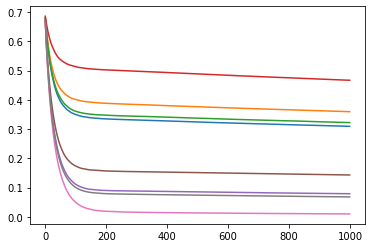

In [103]:
import matplotlib.pyplot as plt
plt.plot(main_result[0]['learn']['MultiClass']) #27.Спортивные мероприятия - синий
plt.plot(main_result[1]['learn']['MultiClass']) # 32. Театр - оранжевый
plt.plot(main_result[2]['learn']['MultiClass']) # 41.Ночной клуб - зеленый
plt.plot(main_result[3]['learn']['MultiClass']) # 45.Кинотеатры - красный
plt.plot(main_result[4]['learn']['MultiClass']) # 67.Доставка еды - фиолетовый светлый
plt.plot(main_result[5]['learn']['MultiClass']) # 73.Выставки - фиолетовый темный
plt.plot(main_result[6]['learn']['MultiClass']) # 81.Билеты на спортивные мероприятия - розовый
plt.plot(main_result[7]['learn']['MultiClass']) # 88.Цирк - черный

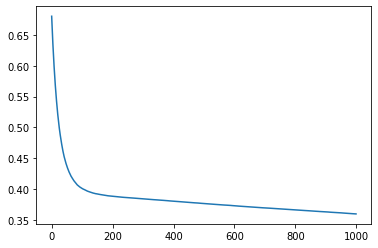

In [87]:
plt.plot(main_result[1]['learn']['MultiClass']) #32.Театр


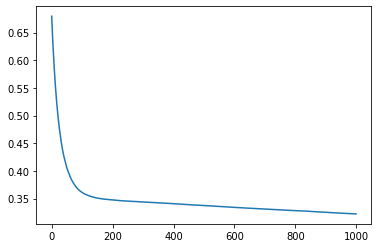

In [90]:
plt.plot(main_result[2]['learn']['MultiClass']) #33. Ночные клубы